In [45]:
import pandas as pd

from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline


In [46]:
df=pd.read_csv('Mall_Customers.csv')

In [47]:
df


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [48]:
#Checking the number of shapes and columns in the dataset
df.shape

(200, 5)

In [49]:
#getting the column type and null values and null values percentage in the database
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=pd.concat([tab_info,pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'})])
tab_info=pd.concat([tab_info,pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'})])
tab_info


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
column type,int64,object,int64,int64,int64
null values (nb),0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0


In [50]:
#checking if duplicates exist in the dataset
dups = df.duplicated()
print(dups)
# report if there are any duplicates
print(dups.any())
# list all duplicate rows
print(df[dups].shape[0]) #or print(dups.sum())
print(df[dups])


0      False
1      False
2      False
3      False
4      False
       ...  
195    False
196    False
197    False
198    False
199    False
Length: 200, dtype: bool
False
0
Empty DataFrame
Columns: [CustomerID, Gender, Age, Annual Income (k$), Spending Score (1-100)]
Index: []


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


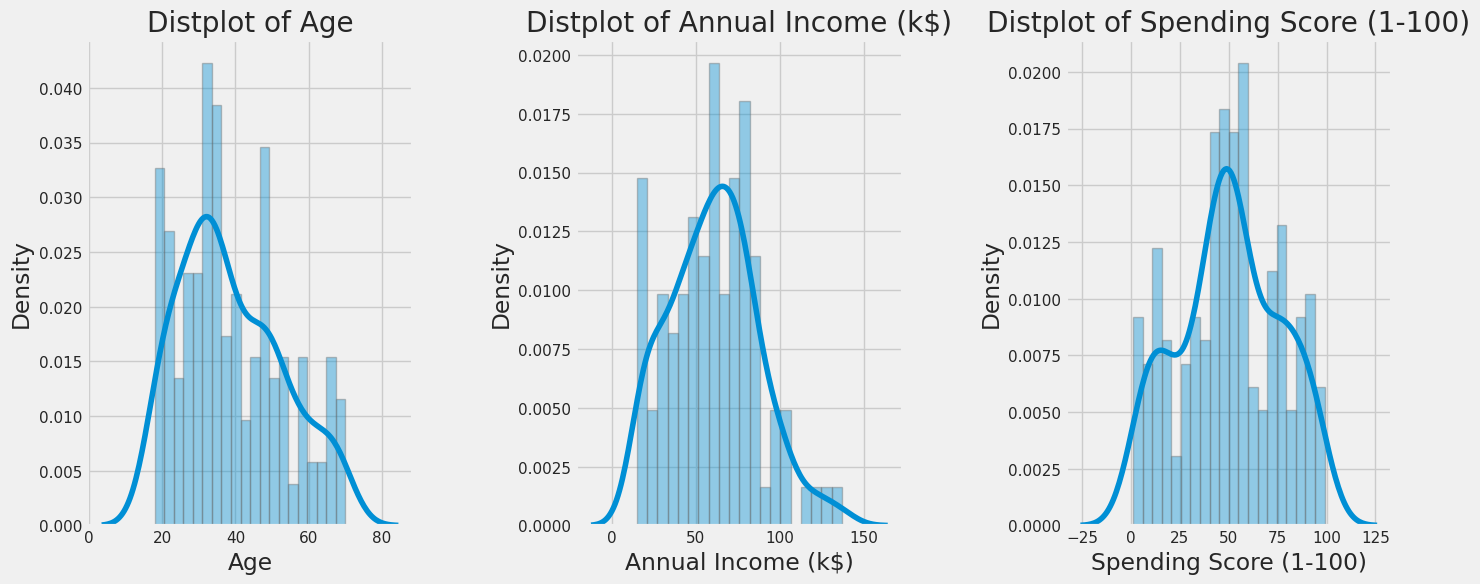

In [52]:
plt.figure(1,figsize=(15,6))
n=0
for x in ['Age','Annual Income (k$)','Spending Score (1-100)']:
    n+=1
    plt.subplot(1,3,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    sns.distplot(df[x],bins=20)
    plt.title('Distplot of {}'.format(x))
plt.show()

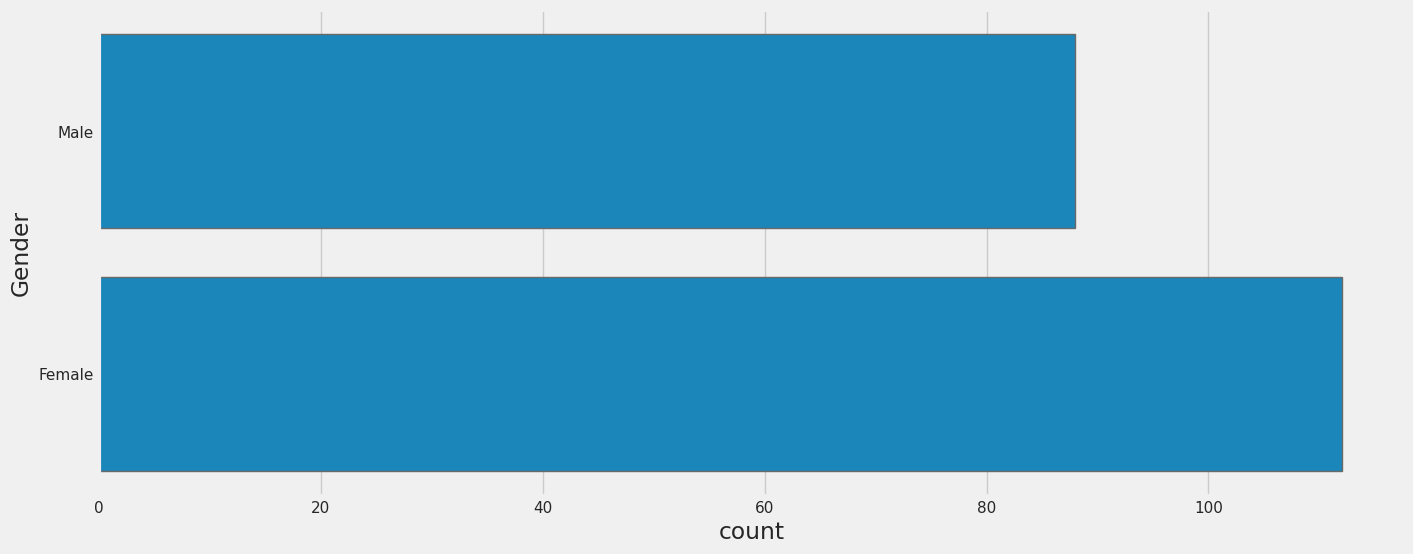

In [53]:
plt.figure(1,figsize=(15,6))
sns.countplot(y='Gender',data=df)
plt.show()

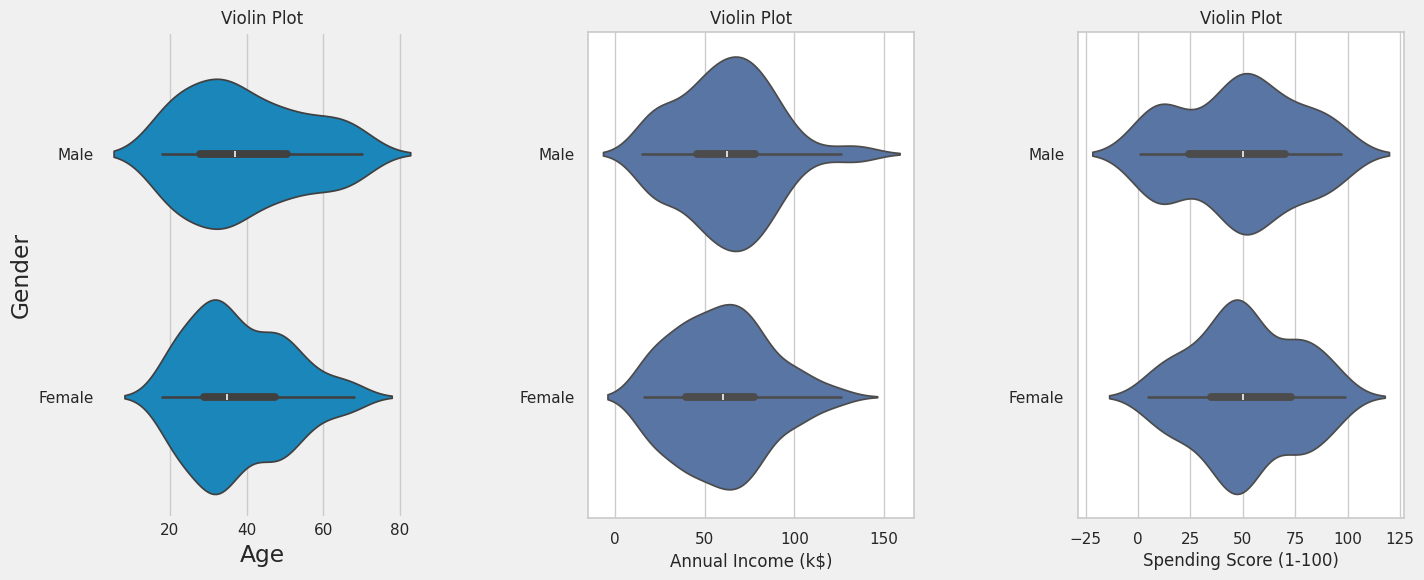

In [54]:
plt.figure(1,figsize=(15,6))
n=0
for cols in ['Age','Annual Income (k$)','Spending Score (1-100)']:
    n+=1
    plt.subplot(1,3,n)
    sns.set(style='whitegrid')
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    sns.violinplot(x=cols,y='Gender',data=df)
    plt.ylabel('Gender' if n==1 else '')
    plt.title('Violin Plot')
plt.show()

Text(0, 0.5, 'Number of Customer')

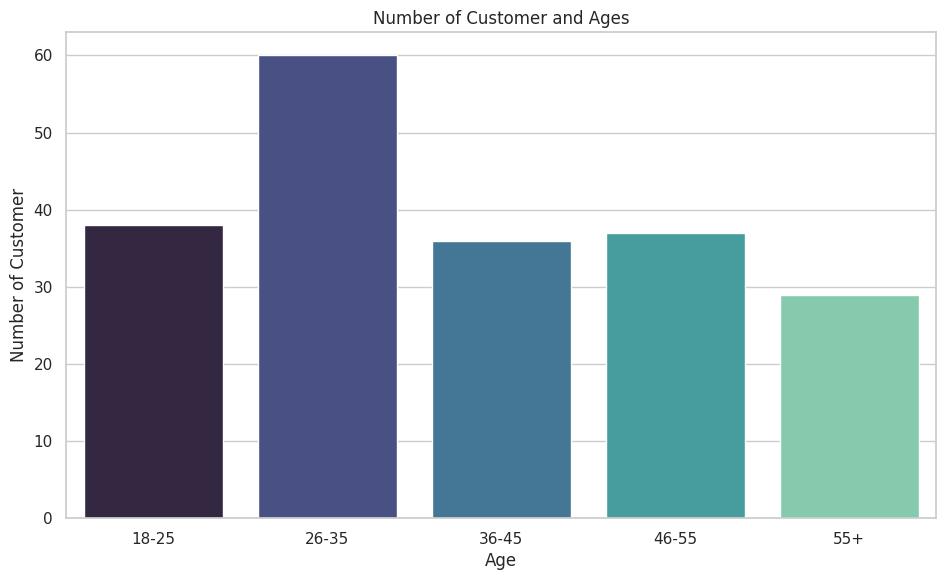

In [55]:
age_18_25 = df.Age[(df.Age >= 18) & (df.Age <= 25)]
age_26_35 = df.Age[(df.Age >= 26) & (df.Age <= 35)]
age_36_45 = df.Age[(df.Age >= 36) & (df.Age <= 45)]
age_46_55 = df.Age[(df.Age >= 46) & (df.Age <= 55)]
age_55above = df.Age[(df.Age >= 56)]

agex = ["18-25","26-35","36-45","46-55","55+"]
agey = [len(age_18_25.values),len(age_26_35.values),len(age_36_45.values),len(age_46_55.values),len(age_55above.values)]

plt.figure(figsize=(10,6))
sns.barplot(x=agex,y=agey,palette="mako")
plt.title("Number of Customer and Ages")
plt.xlabel("Age")
plt.ylabel("Number of Customer")

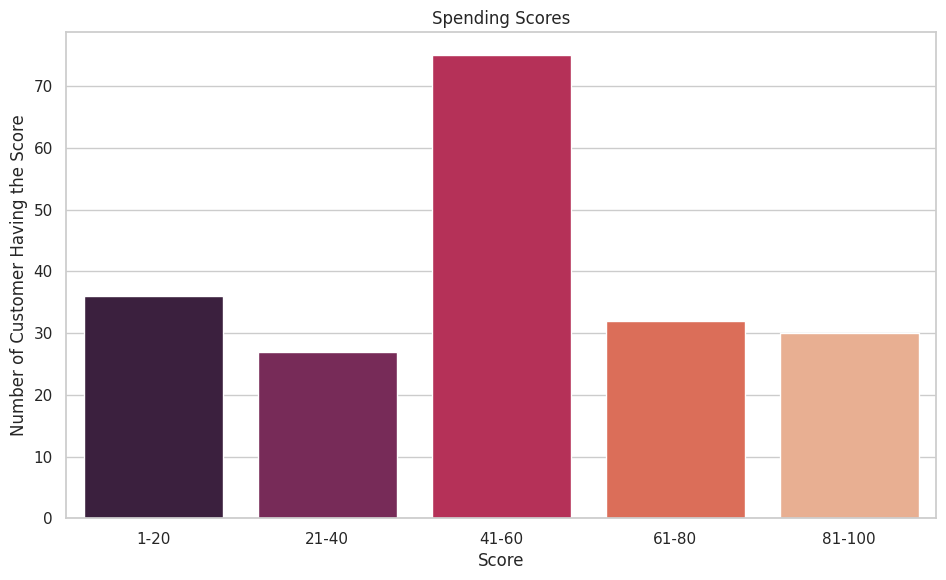

In [56]:
ss_1_20 = df["Spending Score (1-100)"][(df["Spending Score (1-100)"] >= 1) & (df["Spending Score (1-100)"] <= 20)]
ss_21_40 = df["Spending Score (1-100)"][(df["Spending Score (1-100)"] >= 21) & (df["Spending Score (1-100)"] <= 40)]
ss_41_60 = df["Spending Score (1-100)"][(df["Spending Score (1-100)"] >= 41) & (df["Spending Score (1-100)"] <= 60)]
ss_61_80 = df["Spending Score (1-100)"][(df["Spending Score (1-100)"] >= 61) & (df["Spending Score (1-100)"] <= 80)]
ss_81_100 = df["Spending Score (1-100)"][(df["Spending Score (1-100)"] >= 81) & (df["Spending Score (1-100)"] <= 100)]

ssx=["1-20","21-40","41-60","61-80","81-100"]
ssy=[len(ss_1_20.values),len(ss_21_40.values),len(ss_41_60.values),len(ss_61_80.values),len(ss_81_100.values)]

plt.figure(figsize=(10,6))
sns.barplot(x=ssx,y=ssy,palette="rocket")
plt.title("Spending Scores")
plt.xlabel("Score")
plt.ylabel("Number of Customer Having the Score")
plt.show()

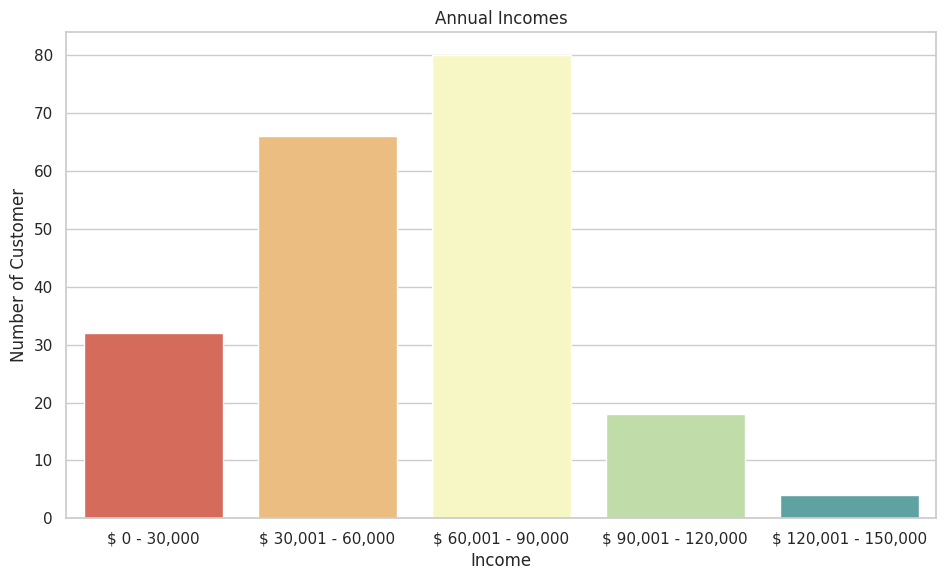

In [57]:
ai0_30 = df["Annual Income (k$)"][(df["Annual Income (k$)"] >= 0) & (df["Annual Income (k$)"] <= 30)]
ai31_60 = df["Annual Income (k$)"][(df["Annual Income (k$)"] >= 31) & (df["Annual Income (k$)"] <= 60)]
ai61_90 = df["Annual Income (k$)"][(df["Annual Income (k$)"] >= 61) & (df["Annual Income (k$)"] <= 90)]
ai91_120 = df["Annual Income (k$)"][(df["Annual Income (k$)"] >= 91) & (df["Annual Income (k$)"] <= 120)]
ai121_150 = df["Annual Income (k$)"][(df["Annual Income (k$)"] >= 121) & (df["Annual Income (k$)"] <= 150)]

aix=["$ 0 - 30,000","$ 30,001 - 60,000","$ 60,001 - 90,000","$ 90,001 - 120,000","$ 120,001 - 150,000"]
aiy=[len(ai0_30.values),len(ai31_60.values),len(ai61_90.values),len(ai91_120.values),len(ai121_150.values)]

plt.figure(figsize=(10,6))
sns.barplot(x=aix,y=aiy,palette="Spectral")
plt.title("Annual Incomes")
plt.xlabel("Income")
plt.ylabel("Number of Customer")
plt.show()

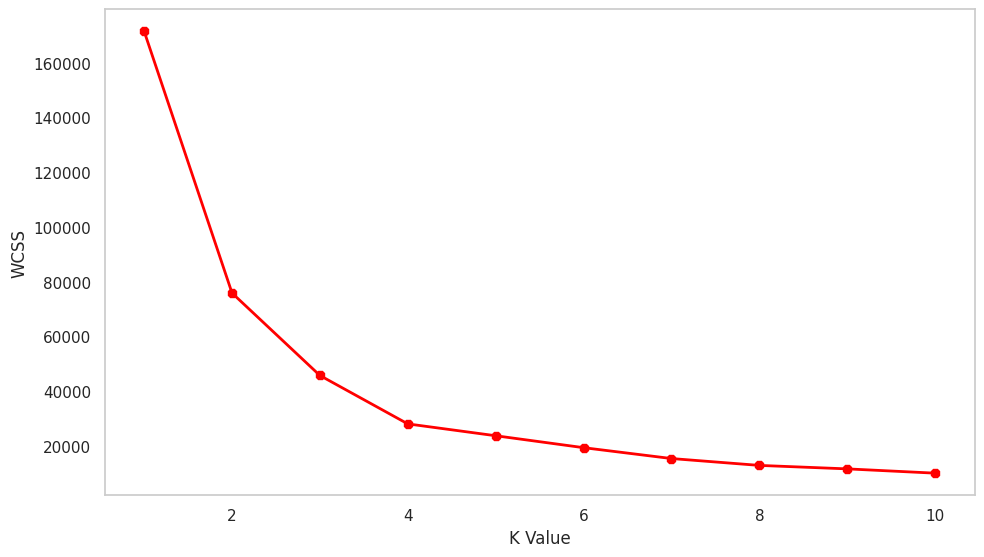

In [58]:
X1=df.loc[:,['Age','Spending Score (1-100)']].values

from sklearn.cluster import KMeans
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)

plt.figure(1,figsize=(10,6))
plt.grid()
plt.plot(range(1,11),wcss,linewidth=2,color='red',marker='8')
plt.xlabel('K Value')
plt.ylabel('WCSS')
plt.show()

In [59]:
from sklearn.metrics import silhouette_score
for n_clusters in range(2,11):
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++',max_iter=300, random_state=142).fit(X1)
    preds = clusterer.predict(X1)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(X1, preds, metric='mahalanobis')
    print ("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.36937044281592746
For n_clusters = 3. The average silhouette_score is : 0.31305465494792084
For n_clusters = 4. The average silhouette_score is : 0.4213729705768663
For n_clusters = 5. The average silhouette_score is : 0.42138443733927133
For n_clusters = 6. The average silhouette_score is : 0.40670647184949915
For n_clusters = 7. The average silhouette_score is : 0.4084298964069805
For n_clusters = 8. The average silhouette_score is : 0.39450893117085684
For n_clusters = 9. The average silhouette_score is : 0.34338169632448823
For n_clusters = 10. The average silhouette_score is : 0.35613939243433024


In [60]:
#for k=4
kmeans = KMeans(n_clusters=4, init='k-means++')

# return a label for each data point based on their cluster
Y1 = kmeans.fit_predict(X1)

print(Y1)

[1 0 2 0 1 0 2 0 2 0 2 0 2 0 2 0 1 1 2 0 1 0 2 0 2 0 2 1 2 0 2 0 2 0 2 0 2
 0 2 0 3 0 3 1 2 1 3 1 1 1 3 1 1 3 3 3 3 3 1 3 3 1 3 3 3 1 3 3 1 1 3 3 3 3
 3 1 3 1 1 3 3 1 3 3 1 3 3 1 1 3 3 1 3 1 1 1 3 1 3 1 1 3 3 1 3 1 3 3 3 3 3
 1 1 1 1 1 3 3 3 3 1 1 1 0 1 0 3 0 2 0 2 0 1 0 2 0 2 0 2 0 2 0 1 0 2 0 3 0
 2 0 2 0 2 0 2 0 2 0 2 0 3 0 2 0 2 0 2 0 2 1 2 0 2 0 2 0 2 0 2 0 2 0 2 0 1
 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0]


In [61]:
print(kmeans.cluster_centers_)

[[30.1754386  82.35087719]
 [27.61702128 49.14893617]
 [43.29166667 15.02083333]
 [55.70833333 48.22916667]]


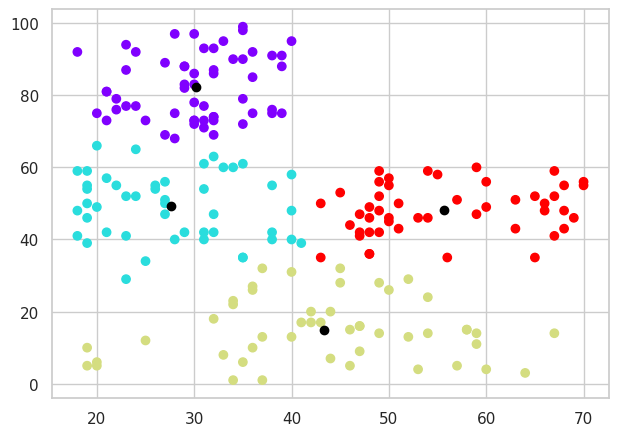

In [62]:
plt.scatter(X1[:, 0], X1[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black')
plt.show()


In [63]:
#for k=5
kmeans = KMeans(n_clusters=5, init='k-means++')

# return a label for each data point based on their cluster
Y1 = kmeans.fit_predict(X1)

print(Y1)

[3 2 4 2 3 2 4 2 0 2 0 2 0 2 4 2 3 3 0 2 3 2 0 2 0 2 0 3 4 2 0 2 0 2 0 2 0
 2 4 2 1 2 1 3 0 3 1 3 3 3 1 3 3 1 1 1 1 1 3 1 1 3 1 1 1 3 1 1 3 3 1 1 1 1
 1 3 1 3 3 1 1 3 1 1 3 1 1 3 3 1 1 3 1 3 3 3 1 3 1 3 3 1 1 3 1 3 1 1 1 1 1
 3 3 3 3 3 1 1 1 1 3 3 3 2 4 2 1 2 0 2 0 2 3 2 4 2 0 2 4 2 0 2 3 2 4 2 1 2
 4 2 0 2 0 2 0 2 4 2 4 2 1 2 4 2 0 2 0 2 4 3 4 2 4 2 0 2 0 2 0 2 4 2 0 2 3
 2 0 2 4 2 4 2 4 2 0 2 0 2 4 2]


In [64]:
print(kmeans.cluster_centers_)

[[51.17857143 15.53571429]
 [55.70833333 48.22916667]
 [30.1754386  82.35087719]
 [27.7173913  49.58695652]
 [31.80952381 15.        ]]


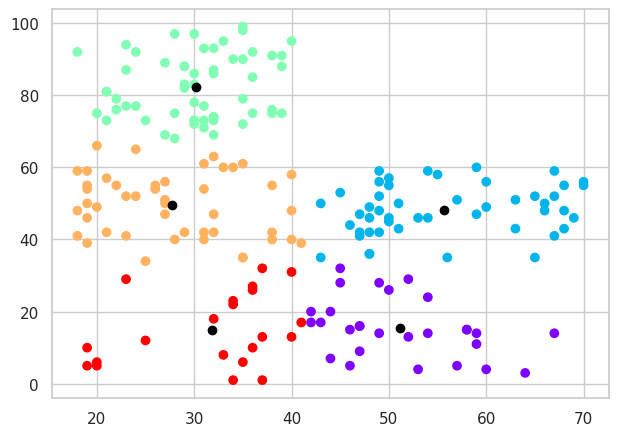

In [65]:
plt.scatter(X1[:, 0], X1[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black')
plt.show()


In [68]:
#making a training dataset with annual income and spending score
X2=df.iloc[:,[3,4]]


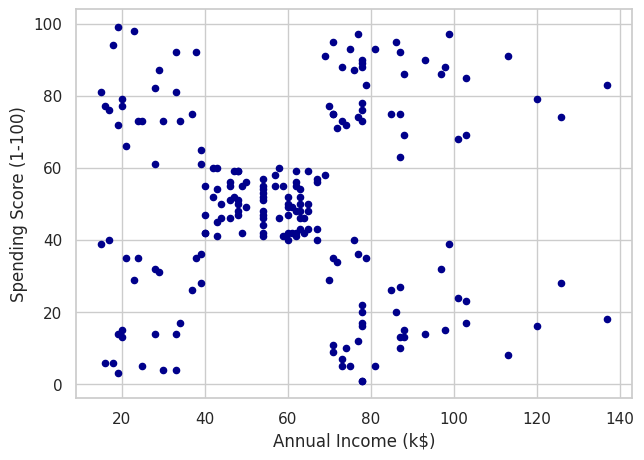

In [69]:
# Creating a scatter plot
ax = X2.plot.scatter(x='Annual Income (k$)', y='Spending Score (1-100)', c='DarkBlue')
plt.show()

In [70]:
#finding the number of clusters
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans.fit(X2)
    wcss.append(kmeans.inertia_)

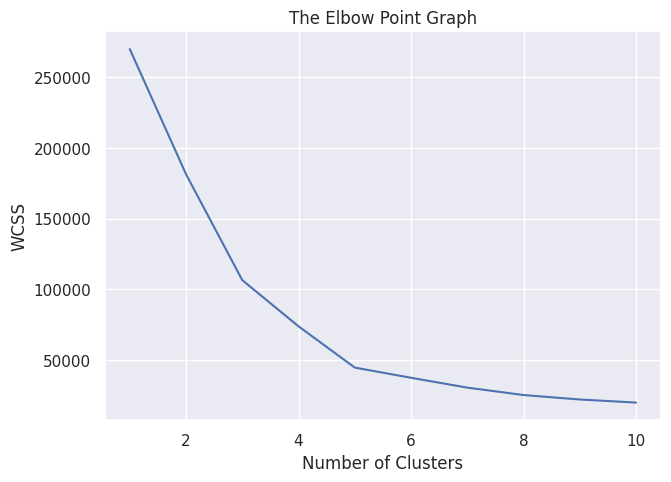

In [71]:
import seaborn as sns
sns.set()
plt.plot(range(1,11), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [72]:
from sklearn.metrics import silhouette_score
for n_clusters in range(2,6):
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++',max_iter=300, random_state=142).fit(X2)
    preds = clusterer.predict(X2)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(X2, preds, metric='mahalanobis')
    print ("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.2933542948173064
For n_clusters = 3. The average silhouette_score is : 0.46654568650366274
For n_clusters = 4. The average silhouette_score is : 0.4928381241627605
For n_clusters = 5. The average silhouette_score is : 0.5545856613152463


In [74]:
kmeans = KMeans(n_clusters=5, init='k-means++')

# return a label for each data point based on their cluster
Y = kmeans.fit_predict(X2)

print(Y)

[2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2
 4 2 4 2 4 2 3 2 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 1 0 1 3 1 0 1 0 1 3 1 0 1 0 1 0 1 0 1 3 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


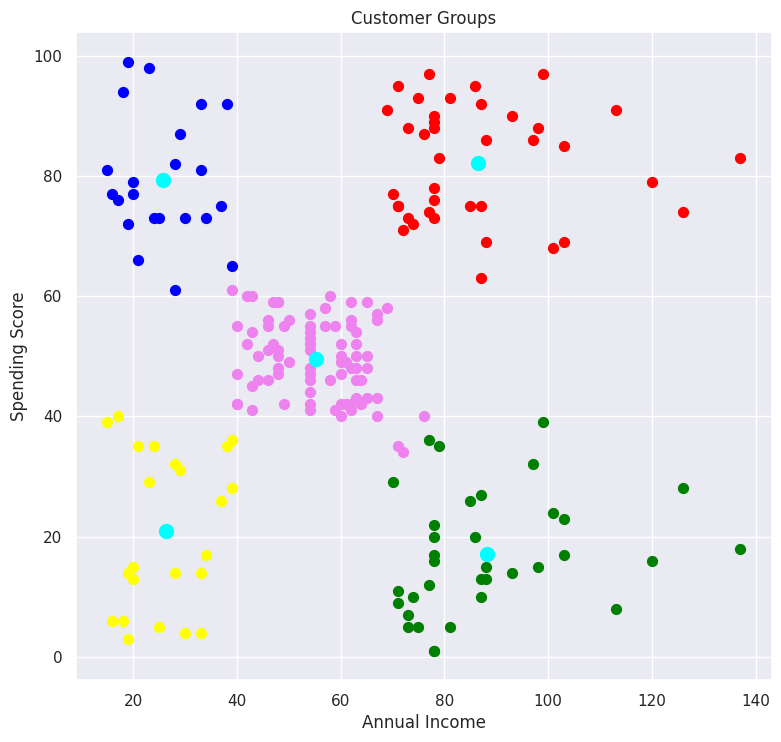

In [76]:
# plotting all the clusters and their Centroids
X2=X2.values

plt.figure(figsize=(8,8))
plt.scatter(X2[Y==0,0], X2[Y==0,1], s=50, c='green', label='Cluster 1')
plt.scatter(X2[Y==1,0], X2[Y==1,1], s=50, c='red', label='Cluster 2')
plt.scatter(X2[Y==2,0], X2[Y==2,1], s=50, c='yellow', label='Cluster 3')
plt.scatter(X2[Y==3,0], X2[Y==3,1], s=50, c='violet', label='Cluster 4')
plt.scatter(X2[Y==4,0], X2[Y==4,1], s=50, c='blue', label='Cluster 5')

# plot the centroids
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='cyan', label='Centroids')

plt.title('Customer Groups')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.show()

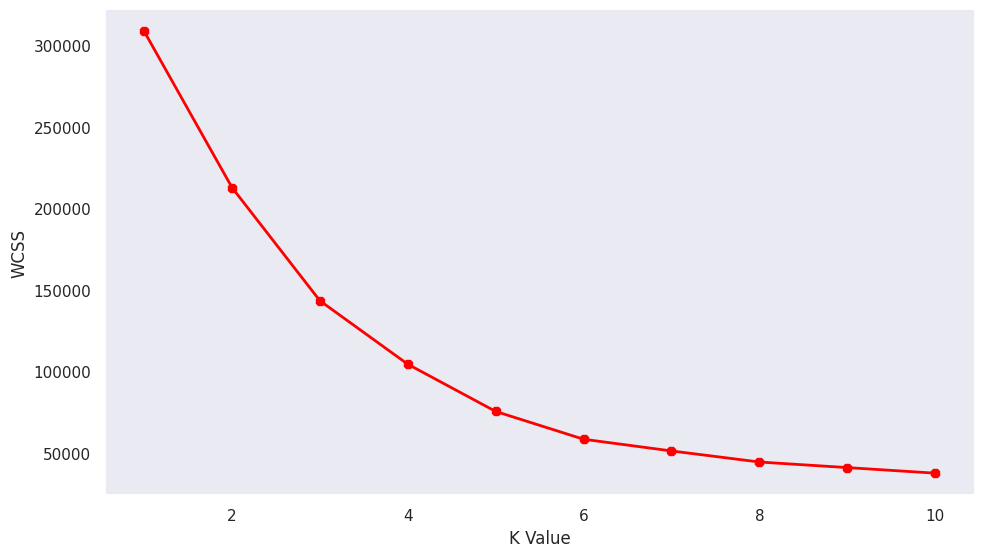

In [77]:
X3=df.iloc[:,2:]
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)
plt.figure(1,figsize=(10,6))
plt.grid()
plt.plot(range(1,11),wcss,linewidth=2,color='red',marker='8')
plt.xlabel('K Value')
plt.ylabel('WCSS')
plt.show()

In [78]:
from sklearn.metrics import silhouette_score
for n_clusters in range(2,11):
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++',max_iter=300, random_state=142).fit(X3)
    preds = clusterer.predict(X3)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(X3, preds, metric='mahalanobis')
    print ("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.25278535468463803
For n_clusters = 3. The average silhouette_score is : 0.2960299230286046
For n_clusters = 4. The average silhouette_score is : 0.32122884479315916
For n_clusters = 5. The average silhouette_score is : 0.33581155664479523
For n_clusters = 6. The average silhouette_score is : 0.42638338208960636
For n_clusters = 7. The average silhouette_score is : 0.39793792545962575
For n_clusters = 8. The average silhouette_score is : 0.37806845756666746
For n_clusters = 9. The average silhouette_score is : 0.35247221671226114
For n_clusters = 10. The average silhouette_score is : 0.3277904515202701


In [79]:
kmeans = KMeans(n_clusters=5, init='k-means++')

# return a label for each data point based on their cluster
Y3 = kmeans.fit_predict(X3)

print(Y3)

[4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4
 3 4 3 4 3 4 3 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 0 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 0 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]


In [80]:
print(kmeans.cluster_centers_)

[[43.08860759 55.29113924 49.56962025]
 [40.66666667 87.75       17.58333333]
 [32.69230769 86.53846154 82.12820513]
 [25.52173913 26.30434783 78.56521739]
 [45.2173913  26.30434783 20.91304348]]


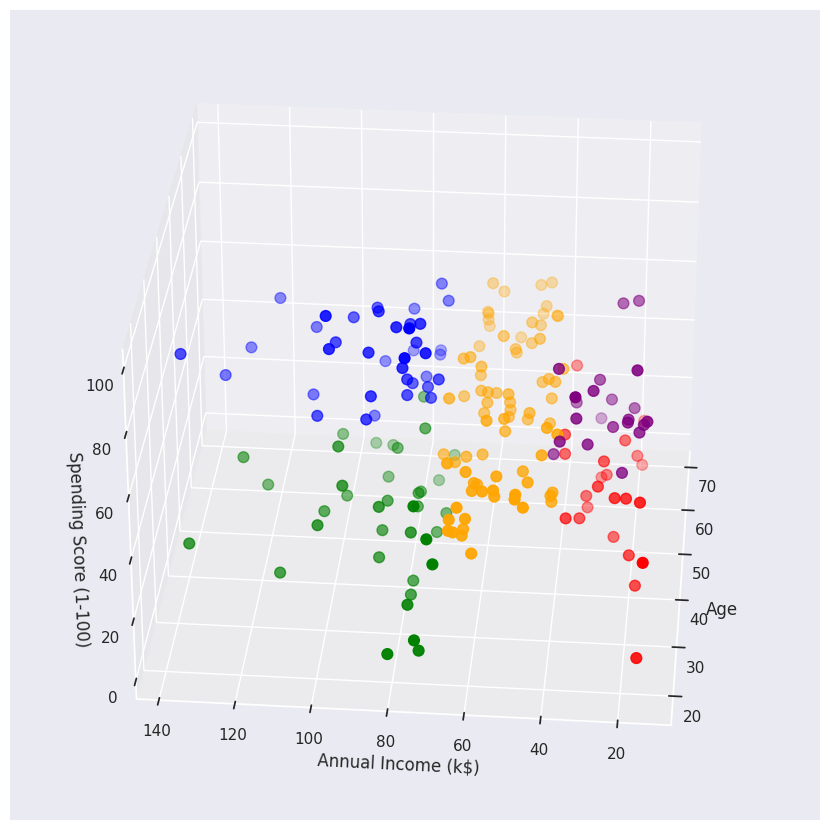

In [81]:
clusters=kmeans.fit_predict(X3)
df['label']=clusters
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Age[df.label == 0], df["Annual Income (k$)"][df.label == 0], df["Spending Score (1-100)"][df.label == 0], c='blue', s=60)
ax.scatter(df.Age[df.label == 1], df["Annual Income (k$)"][df.label == 1], df["Spending Score (1-100)"][df.label == 1], c='red', s=60)
ax.scatter(df.Age[df.label == 2], df["Annual Income (k$)"][df.label == 2], df["Spending Score (1-100)"][df.label == 2], c='green', s=60)
ax.scatter(df.Age[df.label == 3], df["Annual Income (k$)"][df.label == 3], df["Spending Score (1-100)"][df.label == 3], c='orange', s=60)
ax.scatter(df.Age[df.label == 4], df["Annual Income (k$)"][df.label == 4], df["Spending Score (1-100)"][df.label == 4], c='purple', s=60)
ax.view_init(30, 185)

plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.show()

In [82]:
kmeans = KMeans(n_clusters=6, init='k-means++')

# return a label for each data point based on their cluster
Y3 = kmeans.fit_predict(X3)

print(Y3)

[4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4
 3 4 3 1 3 1 5 4 3 1 5 5 5 1 5 5 1 1 1 1 1 5 1 1 5 1 1 1 5 1 1 5 5 1 1 1 1
 1 5 1 5 5 1 1 5 1 1 5 1 1 5 5 1 1 5 1 5 5 5 1 5 1 5 5 1 1 5 1 5 1 1 1 1 1
 5 5 5 5 5 1 1 1 1 5 5 5 0 5 0 2 0 2 0 2 0 5 0 2 0 2 0 2 0 2 0 5 0 2 0 2 0
 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2
 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0]


In [83]:
print(kmeans.cluster_centers_)

[[32.69230769 86.53846154 82.12820513]
 [56.15555556 53.37777778 49.08888889]
 [41.68571429 88.22857143 17.28571429]
 [25.27272727 25.72727273 79.36363636]
 [44.14285714 25.14285714 19.52380952]
 [27.         56.65789474 49.13157895]]


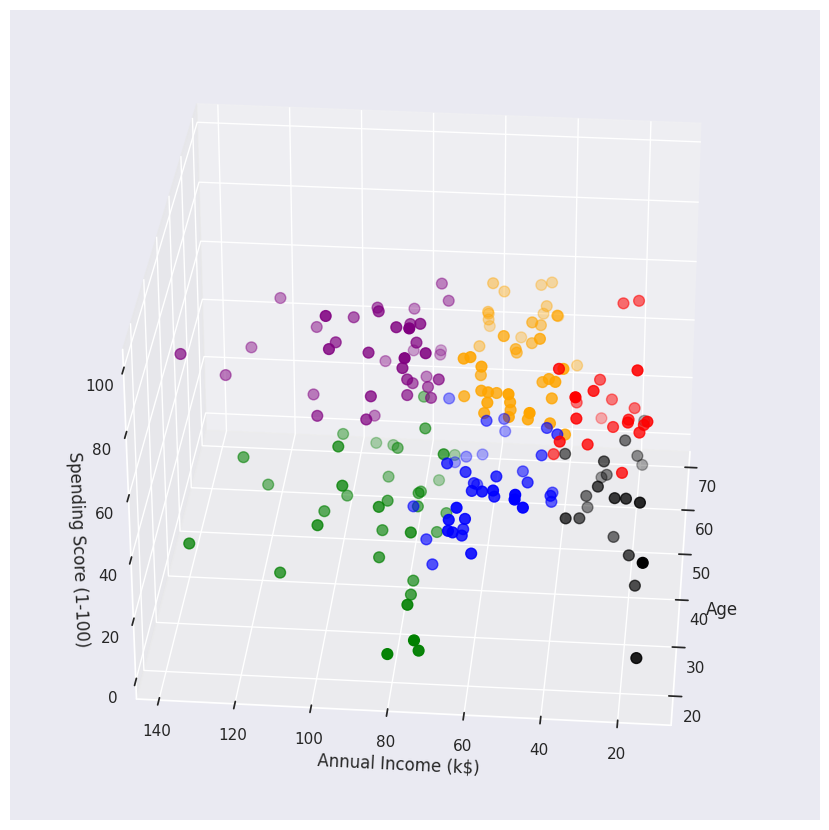

In [84]:
clusters=kmeans.fit_predict(X3)
df['label']=clusters
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Age[df.label == 0], df["Annual Income (k$)"][df.label == 0], df["Spending Score (1-100)"][df.label == 0], c='blue', s=60)
ax.scatter(df.Age[df.label == 1], df["Annual Income (k$)"][df.label == 1], df["Spending Score (1-100)"][df.label == 1], c='red', s=60)
ax.scatter(df.Age[df.label == 2], df["Annual Income (k$)"][df.label == 2], df["Spending Score (1-100)"][df.label == 2], c='green', s=60)
ax.scatter(df.Age[df.label == 3], df["Annual Income (k$)"][df.label == 3], df["Spending Score (1-100)"][df.label == 3], c='orange', s=60)
ax.scatter(df.Age[df.label == 4], df["Annual Income (k$)"][df.label == 4], df["Spending Score (1-100)"][df.label == 4], c='purple', s=60)
ax.scatter(df.Age[df.label == 5], df["Annual Income (k$)"][df.label == 5], df["Spending Score (1-100)"][df.label == 5], c='black', s=60)
ax.view_init(30, 185)

plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.show()